In [5]:
import zipfile

zip_path =  "/content/EuroSAT.zip"

if zipfile.is_zipfile(zip_path):
    print(" Valid ZIP, proceeding to extract.")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("EuroSAT_RGB")
else:
    print(" This is NOT a valid zip file.")


✅ Valid ZIP, proceeding to extract.


In [6]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [7]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 10
DATA_PATH = "EuroSAT_RGB/2750"

# Loading the Data using Image Data Generator

In [8]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


#  Using Pretrained ResNet50 Model

In [9]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


# Compiling

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training

In [11]:

history_base = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.2305 - loss: 2.1182 - val_accuracy: 0.3626 - val_loss: 1.6963
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.4009 - loss: 1.6361 - val_accuracy: 0.4230 - val_loss: 1.5245
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.4509 - loss: 1.5025 - val_accuracy: 0.4557 - val_loss: 1.4416
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.4744 - loss: 1.4406 - val_accuracy: 0.5046 - val_loss: 1.3940
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.4979 - loss: 1.3882 - val_accuracy: 0.5137 - val_loss: 1.3804
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.4954 - loss: 1.3755 - val_accuracy: 0.5119 - val_loss: 1.3275
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.5230 - loss: 1.3182 - val_accuracy: 0.5450 - val_loss: 1.3168
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.5212 - loss: 1.3078 - val_accurac

# Loss and Validation loss

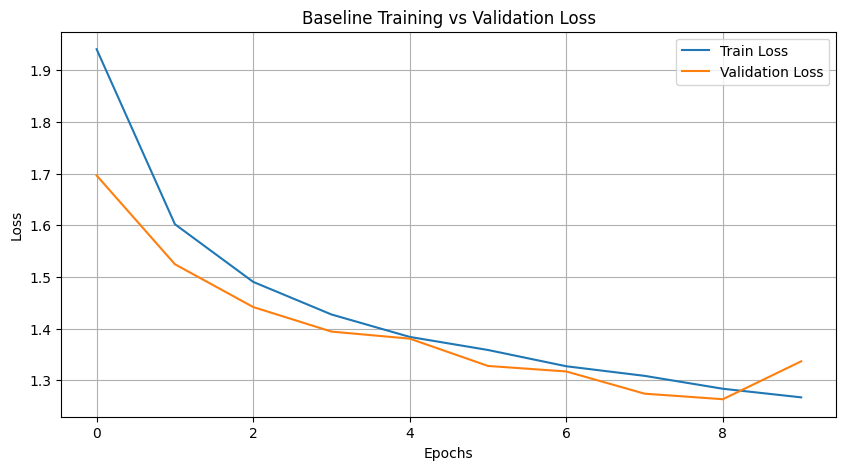

In [12]:

plt.figure(figsize=(10, 5))
plt.plot(history_base.history['loss'], label='Train Loss')
plt.plot(history_base.history['val_loss'], label='Validation Loss')
plt.title('Baseline Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Improving the Model  by Adding  dropout,  early stopping

In [13]:
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [14]:
aug_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

train_aug = aug_datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_aug = aug_datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


#  IMPROVED MODEL

In [15]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compling and Implementing Early Stopping

In [16]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.3, patience=2, monitor='val_loss')
]

#  FINAL TRAINING

In [17]:

history_final = model.fit(
    train_aug,
    validation_data=val_aug,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 73s 90ms/step - accuracy: 0.3955 - loss: 2.0225 - val_accuracy: 0.5520 - val_loss: 1.4219 - learning_rate: 0.0010
Epoch 2/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 55s 82ms/step - accuracy: 0.4766 - loss: 1.5196 - val_accuracy: 0.5893 - val_loss: 1.3191 - learning_rate: 0.0010
Epoch 3/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 55s 82ms/step - accuracy: 0.4962 - loss: 1.4839 - val_accuracy: 0.5661 - val_loss: 1.3113 - learning_rate: 0.0010
Epoch 4/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 58s 87ms/step - accuracy: 0.5091 - loss: 1.4476 - val_accuracy: 0.5756 - val_loss: 1.2943 - learning_rate: 0.0010
Epoch 5/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - accuracy: 0.5066 - loss: 1.4454 - val_accuracy: 0.5998 - val_loss: 1.2602 - learning_rate: 0.0010
Epoch 6/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 82s 82ms/step - accuracy: 0.5070 - loss: 1.4372 - val_accuracy: 0.6059 - val_loss: 1.2581 - learning_rate: 0.0010
Epoch 7/25
675/675 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - accuracy: 0.5021 - l

# Checking Loss Plot

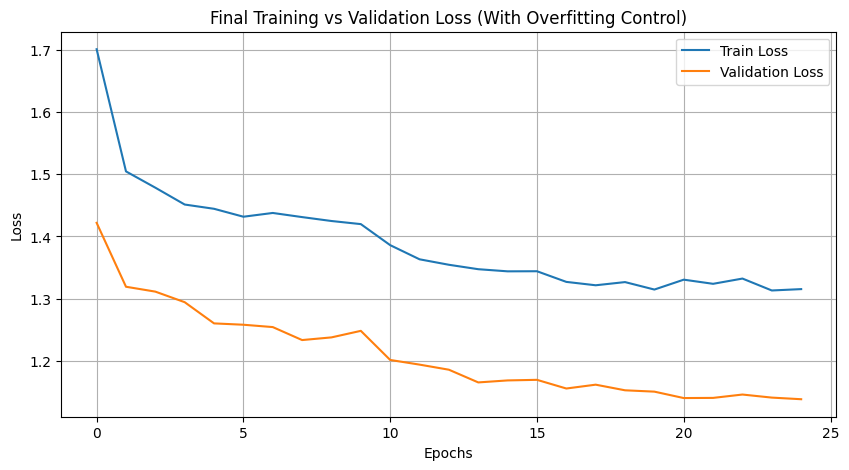

In [18]:

plt.figure(figsize=(10, 5))
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Final Training vs Validation Loss (With Overfitting Control)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# === CLASS LABELS ===
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


IMG_SIZE = (64, 64)


def preprocess_image(img_path, flip=False, change_brightness=False, to_gray=False):


    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")


    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("cv2.imread() returned None. Check if path or file is invalid/corrupted.")


    img = cv2.resize(img, IMG_SIZE)


    if flip:
        img = cv2.flip(img, 1)


    if to_gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)


    if change_brightness:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hsv[..., 2] = np.clip(hsv[..., 2] * 1.3, 0, 255)  # increase brightness
        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)


    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Normalize & expand dims for model input
    img_normalized = img_rgb / 255.0
    img_expanded = np.expand_dims(img_normalized, axis=0)

    return img_expanded, img_rgb


def predict_image(model, img_path, flip=False, change_brightness=False, to_gray=False):
    img_tensor, img_display = preprocess_image(img_path, flip, change_brightness, to_gray)
    prediction = model.predict(img_tensor)[0]

    predicted_index = np.argmax(prediction)
    predicted_label = class_names[predicted_index]
    confidence = prediction[predicted_index] * 100

    # Plot the transformed image with prediction
    plt.imshow(img_display)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label} ({confidence:.2f}%)")
    plt.show()

    return predicted_label, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


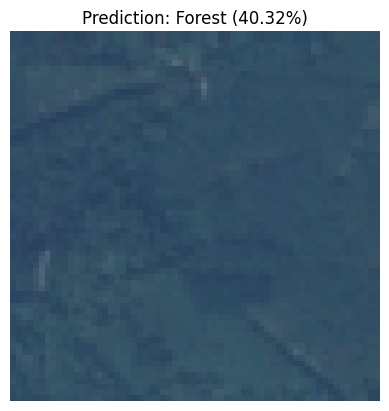

('Forest', np.float32(40.319527))

In [25]:
img_path = "EuroSAT_RGB/2750/Forest/Forest_1.jpg"

# Predict on the image with transformations
predict_image(model, img_path, flip=True, change_brightness=True, to_gray=False)
